# LEEM data cluster analysis - this is still under construction, don't use it!

Please read LEEM_plotting and LEEM_base tutorials first.

Additionally to `agfalta.leem`, we need to import the cluster module and `numpy` and `matplotlib`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from agfalta import leem
from agfalta.leem import cluster, driftnorm

Either do normalization and drift correction if load_new is True (refer to the norm-and-align tutorial). Or use a pre-aligned image stack. For example, load a tif that has been prepared by Fiji.

▕▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▏ 100.0 % Normalizing... (0:00:00)
▕▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▏ 100.0 % Finding keypoints (SIFT)... (0:00:01)
▕▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▏ 100.0 % Matching keypoints... (0:00:00)


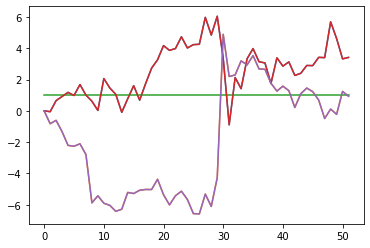

In [2]:
load_new = True

if load_new:
    stack = leem.LEEMStack("../testdata/test_stack_IV_g-Cu")
    stack = driftnorm.normalize(stack, "../testdata/channelplate.dat", dark_counts=110)
    stack, alignment = driftnorm.align(stack, mask_outer=0.2, trafo="translation")
    plt.plot([m[:, 2] for m in alignment])
    plt.plot([m[0, 2] for m in stack.alignment])
    plt.plot([m[1, 2] for m in stack.alignment])
else:
    stack = leem.LEEMStack("../testdata/test_stack_IV_RuO2_normed_aligned_80-140.tif")
    stack.energy = np.linspace(19.0, 30.8, len(stack))     # manually set the energies because the tif does not have them


Stack inspection:

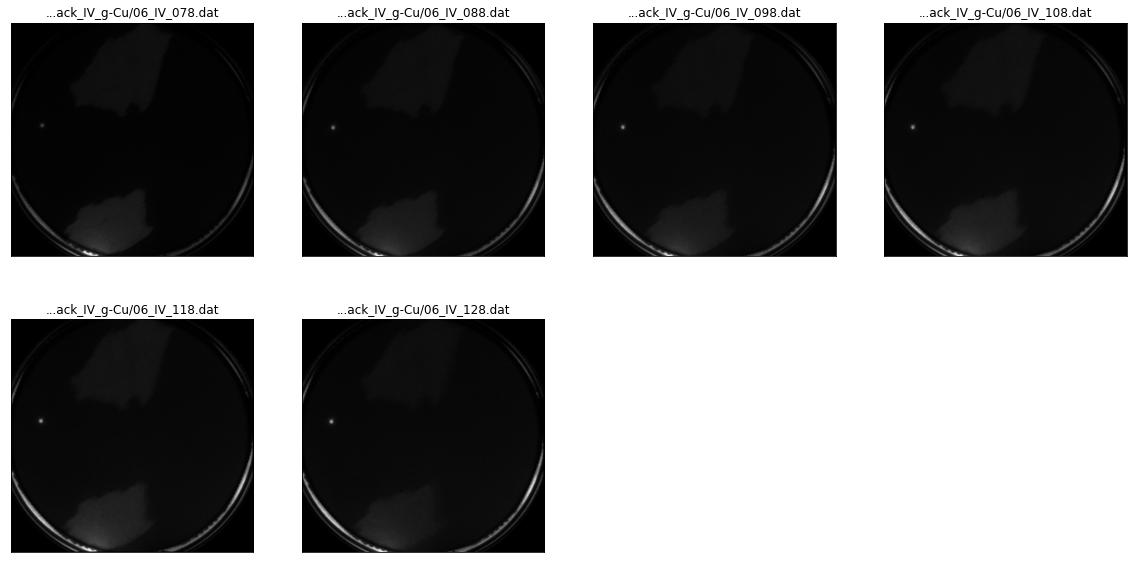

In [3]:
leem.plot_mov(stack, skip=10, fields=None)

For the principal component analysis, the stack has to be reshaped first with `stack2vectors()`. This translates the 3-dimensional stack data into a list of 1-dimensional spectra `X`. The outer parts of the images are cut away because we don't want to include the beam tube. The new height `h` and width `w` are needed later for transforming back into images.

Then, `pendryfy()` applies the Pendry-R-Factor metric. The spectra are transformed into the "Y" that is mentioned in Pendry's paper. This step is not necessary and may be better or worse for different stacks.

Now, `component_analysis()` does what it says and returns 2 functions and a model. It's most important parameter is `n_components`. The functions `trafo` and `inv_trafo` are used to transform between "real spectrum space" and "principal component space". The model holds all information of the analysis. It can be saved via `cluster.save_model(model, filename)` and loaded via `trafo, inv_trafo, model = cluster.load_pca_model(filename)`

In [4]:
X, h, w = cluster.stack2vectors(stack, mask_outer=0.2) # cut away 20% on every side

X = cluster.pendryfy(X, stack.energy)

trafo, inv_trafo, model = cluster.component_analysis(X, "pca", n_components=7)
W = trafo(X)

▕▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▏ 100.0 % Pendryfying... (0:00:32) ETA: 0:00:03)
Started component analysis
PCA: 7 components explain 34.33% of variance: (10.10%, 5.24%, 4.19%, 4.07%, 3.77%, 3.52%, 3.44%, ...)
Finished component analysis in 0:00:01


The resulting `W`-vectorlist has the same format as `X`, but in "PCA-space" and with fewer images. It can be converted into a normal stack and then plotted. The result is one image for each principal component. In this example case, it looks a bit shitty but it suffices to see how it works. The first component has the highest variance, each next component has less variance and ist more noise-like.

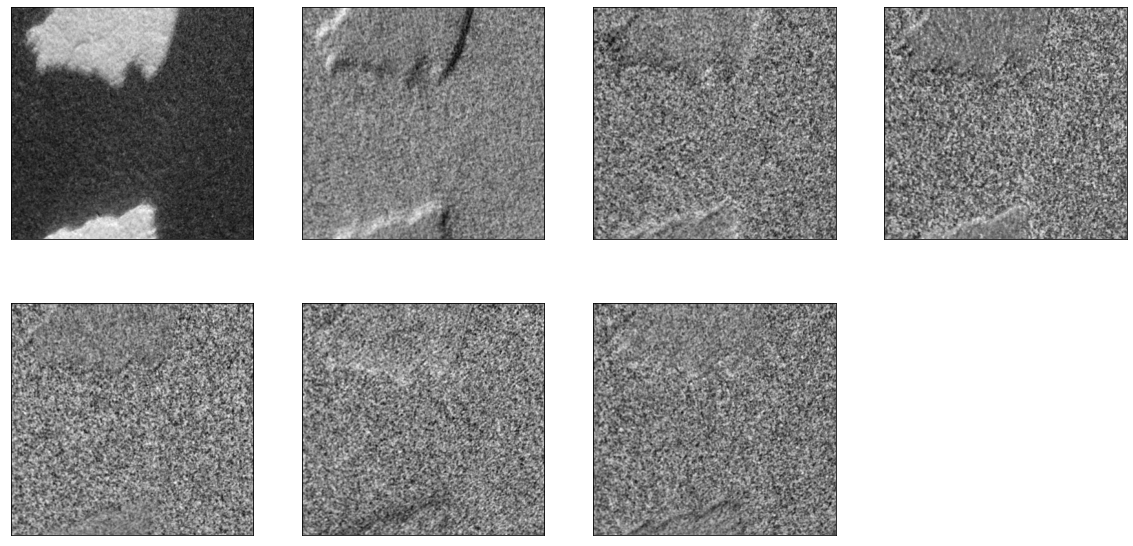

In [5]:
comps = cluster.vectors2stack(W, h, w)
leem.plot_mov(comps, fields=None)

Now follows the actual cluster analysis, which is simple to do. The `cluster_analysis()` function takes different keyword arguments depending on the algorithm and always returns `labels` and a model (can be saved by `save_model(model, filename)` and loaded by `labels, model = load_cluster_model(filename)`).

`labels` has the same format as `X`, but only one image that contains integers (the "cluster number"). `labels` will be ordered in cluster size, so the smallest cluster has label `0` and the next one `1` and so on.

In [6]:
n_clusters = 3
labels, model = cluster.cluster_analysis(W, "pc-kmeans", n_clusters=n_clusters, metric="euclidean_square")

Started cluster analysis
PC-KMEANS: Found 3 clusters
Finished cluster analysis in 0:00:03


To plot the results, the initial stack and its mask is needed to extract the correct IV curves. The labels need to be reshaped correctly. plot_clustermap also takes an argument to change the colors: look up colormaps for matplotlib, a good one is for example "brg".

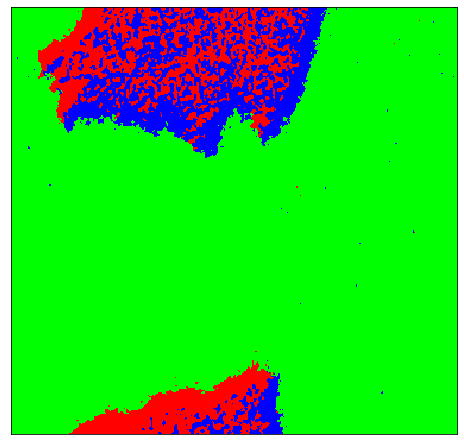

In [7]:
cluster.plot_clustermap(labels.reshape(h, w), cmap="brg")

Maybe we want to look at each cluster separately:

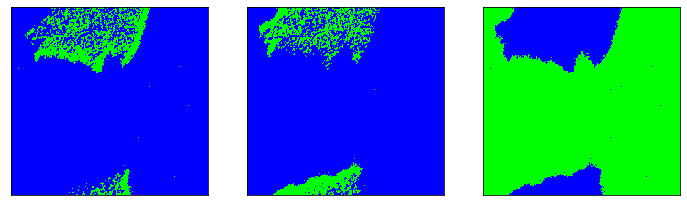

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for i in range(int(labels.max()) + 1):
    single_label = labels == i
    cluster.plot_clustermap(single_label.reshape(h, w), cmap="brg", ax=axes[i])

We can see that two of the labels are really the same phase. Sometimes it is clever to change the number of components in PCA, sometimes it is better to change the number of clusters. And sometimes, we just want to combine to phases manually afterwards. For that, use `cluster.combine_labels()`. It takes the original labels as argument, and a list of "combo-lists", i.e. a list of lists of clusters that belong together.

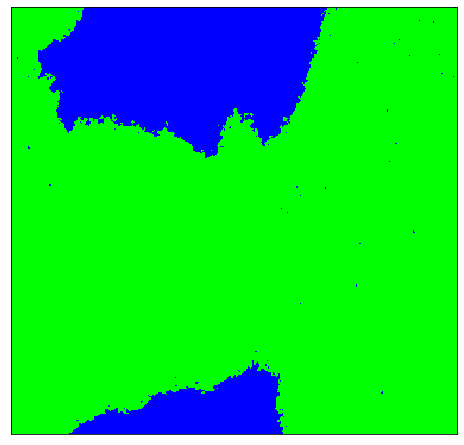

In [20]:
# combine labels: give a list of "combo-lists"
combined_labels = cluster.combine_labels(labels, [[0, 1]])
cluster.plot_clustermap(combined_labels.reshape(h, w), cmap="brg")

Now, to extract the IV curves, you need the original stack and you need to give the `mask_outer` parameter that you used in the `stack2vectors()` function before PCA:

<AxesSubplot:>

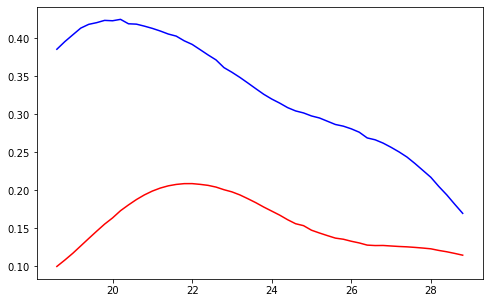

In [21]:
cluster.plot_IVs(stack, combined_labels, mask_outer=0.2, cmap="brg")